# Analysis of Job Ads

Analysis is based on CRISP-DM methodology.

## 1. Business understanding

**Questions:**

* Which sectors have the highest demand for Data Anlalysts?
* TOP 4 skills every Data Analyst should acquire.
* What's the average Salary in the U.S.?

## 2. Data Understanding

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from wordcloud import WordCloud

In [2]:
# NA values are coded as -1
data = pd.read_csv('data/DataAnalyst.csv', index_col=0, na_values=-1)

In [3]:
# Inspect the data
data.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961.0,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),NaN,True
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893.0,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),NaN,NaN
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003.0,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,NaN
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002.0,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),NaN,NaN
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009.0,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


In [4]:
# How many observations and columns do we have?
"{} rows, {} columns".format(*data.shape)

'2253 rows, 15 columns'

In [5]:
# Most of the columns are coded as string.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2253 entries, 0 to 2252
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          2253 non-null   object 
 1   Salary Estimate    2252 non-null   object 
 2   Job Description    2253 non-null   object 
 3   Rating             1981 non-null   float64
 4   Company Name       2252 non-null   object 
 5   Location           2253 non-null   object 
 6   Headquarters       2081 non-null   object 
 7   Size               2090 non-null   object 
 8   Founded            1593 non-null   float64
 9   Type of ownership  2090 non-null   object 
 10  Industry           1900 non-null   object 
 11  Sector             1900 non-null   object 
 12  Revenue            2090 non-null   object 
 13  Competitors        521 non-null    object 
 14  Easy Apply         80 non-null     object 
dtypes: float64(2), object(13)
memory usage: 281.6+ KB


In [6]:
# How many missing values?
# `Easy Apply`, `Founded` and `Competitors` have the most missing values and do not contain important information. I will drop these columns from the analysis
# I will remove observations from columns containing missing values because it would be impossible to impute the values or scrape them from the web.
data.isnull().sum().sort_values(0, False)

Easy Apply           2173
Competitors          1732
Founded               660
Sector                353
Industry              353
Rating                272
Headquarters          172
Revenue               163
Type of ownership     163
Size                  163
Company Name            1
Salary Estimate         1
Location                0
Job Description         0
Job Title               0
dtype: int64

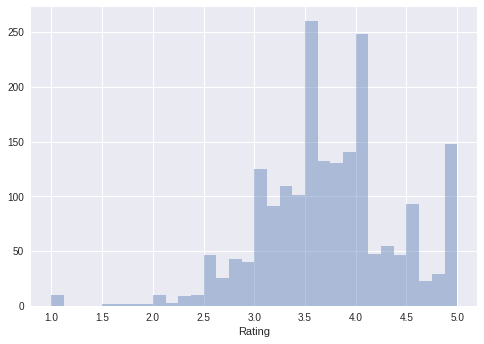

In [7]:
# Distribution of variable `Rating`. Usually the values fall between 0 and 5.
sns.distplot(data['Rating'], kde=False);

* Columns `Salary Estimate` contains min and max estimated values. I will split this column into two.
* Column `Location` - I will extract only State code for aggregation
* Columns `Competitors`, `Founded` and `Easy Apply`  will be removed from the analysis

__Categorical variables:__
* `Size`, `Type of ownership`, `Revenue`, `Sector` and `Industry` have standartized values for all observations

__Text:__
* `Title` - I will try to extract the level (Junior, Mid, Senior)
* `Job description` - I will try to extract hard skills from the text

## 3. Data Preparation (Cleaning)

In [8]:
data_clean = data.copy()

In [9]:
def clean_string(string, text, replace="", split=False):
    """ Replace text within given string and split to MIN and MAX values if neccessary """
    if pd.isnull(string): return None
    cleaned_text = re.sub(text, replace, string)
    if split:
        return re.split("-", cleaned_text)
    else:
        return cleaned_text
    
# Clean Salary column
data_clean[['MIN_Salary', 'MAX_Salary']] = data_clean['Salary Estimate'].apply(clean_string, text=r' \(Glassdoor est.\)|\$|K', split=True).apply(pd.Series)
data_clean['MIN_Salary'] = pd.to_numeric(data_clean['MIN_Salary'], errors='coerce')
data_clean['MAX_Salary'] = pd.to_numeric(data_clean['MAX_Salary'], errors='coerce')

# Clean Revenue column
data_clean['Revenue'] = data_clean['Revenue'].apply(clean_string, text=r"\$| \(USD\)")

In [10]:
# Convert Categrical variables to the right data type

# Company Size
data_clean['Company Size'] = pd.Categorical(data_clean['Size'],
               categories=[
                   '1 to 50 employees', '51 to 200 employees', '201 to 500 employees', '501 to 1000 employees',
                   '1001 to 5000 employees','5001 to 10000 employees', '10000+ employees'],
               ordered=True)

# Revenue
data_clean['Company Revenue'] = pd.Categorical(data_clean['Revenue'],
               categories=[
                   'Less than 1 million', '1 to 5 million', '5 to 10 million', '10 to 25 million', 
                   '25 to 50 million', '50 to 100 million', '100 to 500 million', '500 million to 1 billion',
                   '1 to 2 billion', '2 to 5 billion', '5 to 10 billion', '10+ billion', 'Unknown / Non-Applicable'],
               ordered=True)

In [11]:
# Extract state
data_clean['State'] = data_clean['Location'].str[-2:]

In [12]:
# Drop columns
drop_columns = ['Salary Estimate', 'Location', 'Size', 'Competitors','Easy Apply', 'Founded']
data_clean.drop(drop_columns, axis=1, inplace=True)

In [13]:
data['Type of ownership'].value_counts()

Company - Private                 1273
Company - Public                   452
Nonprofit Organization             124
Subsidiary or Business Segment      89
Government                          37
College / University                34
Hospital                            19
Unknown                             16
Other Organization                  13
Contract                            11
School / School District             9
Private Practice / Firm              9
Franchise                            2
Self-employed                        2
Name: Type of ownership, dtype: int64

In [14]:
# Extract Job level

pattern_principal = re.compile(r'lead|principal|iii|iv',re.I)
pattern_senior = re.compile(r'senior|sr.|sr|ii',re.I)
pattern_junior = re.compile(r'junior|jr|jr.|entry|i',re.I)

def extract_job_title(text):
    """ Extract Job level from Job Title """
    if re.match(pattern_principal, text):
        return "Lead"
    elif re.match(pattern_senior, text):
        return "Senior"
    elif re.match(pattern_junior, text):
        return "Junior"
    
data_clean['Job Level'] = data_clean['Job Title'].apply(extract_job_title)

In [15]:
data_clean['Job Level'].isnull().sum()

1766

In [16]:
data_clean['Type'] = data_clean['Job Title'].str.extract("(\w+) Data")
types = ['Senior', 'Reporting', 'Business','Principal','Junior','Chief','Master']

data_clean.loc[~data_clean['Type'].isin(types), 'Type'] = None
data_clean['Type'].fillna("Regular", inplace=True)

In [17]:
data_clean

,Job Title,Job Description,Rating,Company Name,Headquarters,Type of ownership,Industry,Sector,Revenue,MIN_Salary,MAX_Salary,Company Size,Company Revenue,State,Job Level,Type
0,"Data Analyst, Center on Immigration and Justic...",Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY",Nonprofit Organization,Social Assistance,Non-Profit,100 to 500 million,37.0,66.0,201 to 500 employees,100 to 500 million,NY,None,Regular
1,Quality Data Analyst,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY",Nonprofit Organization,Health Care Services & Hospitals,Health Care,2 to 5 billion,37.0,66.0,10000+ employees,2 to 5 billion,NY,None,Regular
2,"Senior Data Analyst, Insights & Analytics Team...",We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY",Company - Private,Internet,Information Technology,Unknown / Non-Applicable,37.0,66.0,1001 to 5000 employees,Unknown / Non-Applicable,NY,Senior,Senior
3,Data Analyst,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"McLean, VA",Subsidiary or Business Segment,IT Services,Information Technology,50 to 100 million,37.0,66.0,201 to 500 employees,50 to 100 million,NY,None,Regular
4,Reporting Data Analyst,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY",Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",100 to 500 million,37.0,66.0,501 to 1000 employees,100 to 500 million,NY,None,Reporting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248,RQS - IHHA - 201900004460 -1q Data Security An...,Maintains systems to protect data from unautho...,2.5,"Avacend, Inc.\n2.5","Alpharetta, GA",Company - Private,Staffing & Outsourcing,Business Services,Unknown / Non-Applicable,78.0,104.0,51 to 200 employees,Unknown / Non-Applicable,CO,None,Regular
2249,Senior Data Analyst (Corporate Audit),Position:\nSenior Data Analyst (Corporate Audi...,2.9,Arrow Electronics\n2.9,"Centennial, CO",Company - Public,Wholesale,Business Services,10+ billion,78.0,104.0,10000+ employees,10+ billion,CO,Senior,Senior
2250,"Technical Business Analyst (SQL, Data analytic...","Title: Technical Business Analyst (SQL, Data a...",NaN,Spiceorb,NaN,NaN,NaN,NaN,None,78.0,104.0,NaN,NaN,CO,None,Regular
2251,"Data Analyst 3, Customer Experience",Summary\n\nResponsible for working cross-funct...,3.1,Contingent Network Services\n3.1,"West Chester, OH",Company - Private,Enterprise Software & Network Solutions,Information Technology,25 to 50 million,78.0,104.0,201 to 500 employees,25 to 50 million,CO,None,Regular


## 4. Data Modeling

#### 4.1. The background in IT or Business Services will benefit you.

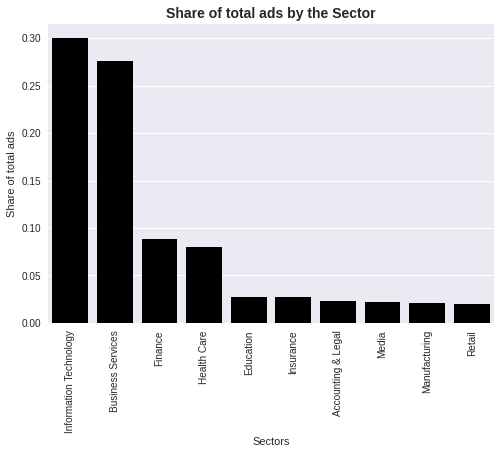

In [18]:
sns.barplot(x='index', y='Sector', data=data_clean['Sector'].value_counts(normalize=True).head(10).reset_index(), color='black')
plt.ylabel('Share of total ads')
plt.xlabel("Sectors")
plt.title("Share of total ads by the Sector", fontdict={'size':14, 'weight':'bold'})
plt.xticks(rotation=90)
plt.savefig("figs/share_by_sector.png", dpi=300, bbox_inches='tight')

### 4.2. SQL and Excel are the most requested skills for Data Analyst

I have taken a look on some ads and manualy stores skills to a dictionary.

After that I had counted how often these skills appear on the ads.

In [19]:
# Create a dict of skills as keys and search patterns as values

hard_skills_dict = {
    "Python / R" : r'python|\bR\b',
    "Visualization tools" : r'powerbi|tableau|looker|plotly|dashboard',
    "Other coding languages" : r'\bC\b|C[#\+\+]|java|vba|scripting|programming',
    "ERP systems": r'\bsas\b|\bsap\b|oracle',
    "Excel" : r'excel',
    "SQL / Databases" : 'sql|mysql|database',
    "Data proccessing engines" : r'hadoop|hive|spark',
#     "Statistics" : r'statistics|statistical',
#     "Programming": r'scripting|coding|programming',
    "Web Services": r'aws|azure|gcp',
}

In [20]:
hard_skills = {}

# Loop through skills, and count the frequency
for key, search in hard_skills_dict.items():
    hard_skills[key] = data_clean['Job Description'].str.contains(search, flags=re.IGNORECASE).sum()
    data_clean[key] = data_clean['Job Description'].str.contains(search, flags=re.IGNORECASE)

# Build a DataFrame of skills, counts and frequencies.
skills = pd.DataFrame.from_dict(hard_skills, orient='index').reset_index().rename({'index':'skill', 0:'count'}, axis=1).sort_values('count', 0, False)
skills['freq'] = skills['count'] / data_clean.shape[0]

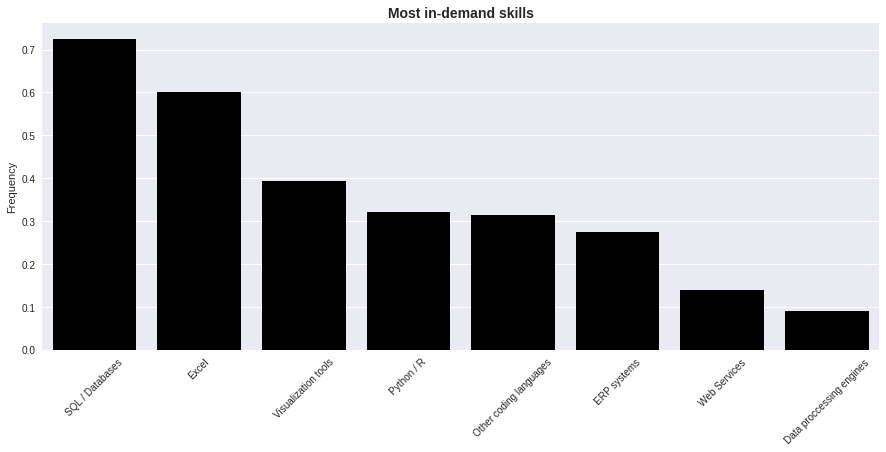

In [21]:
# Plot a barchart of skills
plt.figure(figsize=(15, 6))
sns.barplot(x='skill', y='freq', data=skills, color='k')
plt.xticks(rotation=45)
plt.title("Most in-demand skills", fontdict={'size':14, 'weight':'bold'})
plt.ylabel("Frequency")
plt.xlabel("")
plt.savefig("figs/skills.png", dpi=300, bbox_inches='tight')

### 4.3 Demand vs. Salary

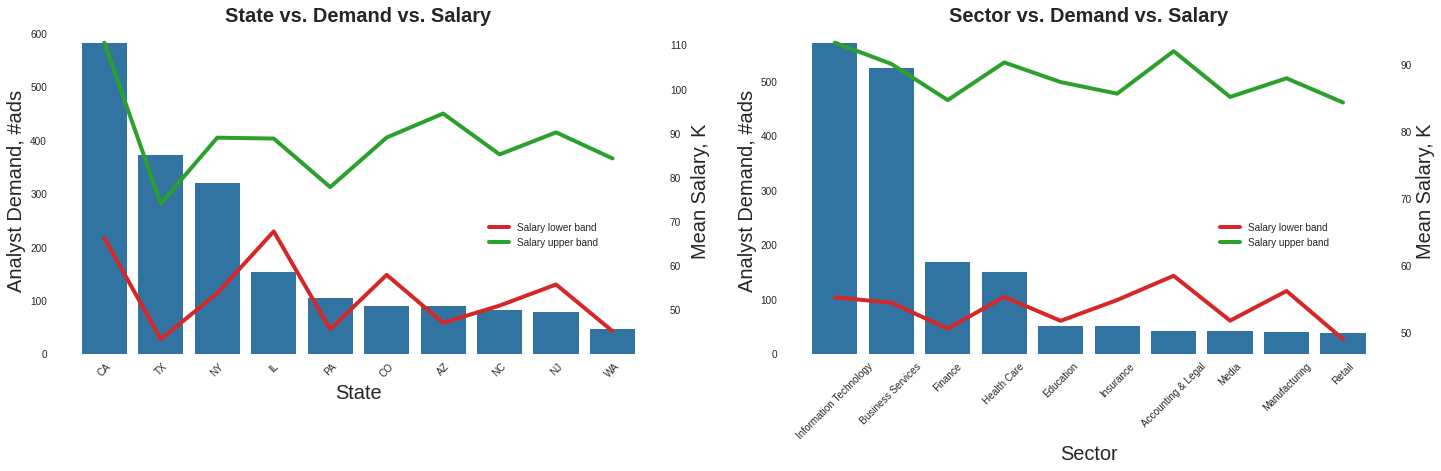

In [22]:
x1 = 'State'
x2 = 'Sector'

plot_data1 = data_clean.groupby(x1, as_index=False).agg({'MIN_Salary':'mean', 'MAX_Salary':'mean', 'Revenue':'count'}).sort_values('Revenue', 0, False).head(10)
plot_data2 = data_clean.groupby(x2, as_index=False).agg({'MIN_Salary':'mean', 'MAX_Salary':'mean', 'Revenue':'count'}).sort_values('Revenue', 0, False).head(10)

# Figure on the left side
plt.figure(figsize=(24,6))
ax = plt.subplot(121, )
sns.barplot(x=x1, y='Revenue', data=plot_data1,color='tab:blue', label="Ads count", ax=ax)
ax.tick_params(labelsize=10,rotation=45,axis='x') 
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xlabel('State',fontsize=20)
ax.grid(False)
ax2 = ax.twinx() 

ax2.spines['top'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['left'].set_color('none')

ax.set_ylabel('Analyst Demand, #ads',fontsize=20)
sns.lineplot(data=plot_data1, x=x1,y='MIN_Salary',ax=ax2, sort=False, linewidth=4, color='tab:red', label="Salary lower band")
sns.lineplot(data=plot_data1, x=x1,y='MAX_Salary',ax=ax2, sort=False, linewidth=4, color='tab:green', label='Salary upper band')
ax2.set_ylabel('Mean Salary, K',fontsize=20)
ax2.grid(False)
ax2.legend(bbox_to_anchor=(.7,.3))
ax.set_facecolor("white")

plt.title('State vs. Demand vs. Salary',fontsize=20, fontweight='bold')

# Figure on the right side
ax = plt.subplot(122)
sns.barplot(x=x2, y='Revenue', data=plot_data2,color='tab:blue', label="Ads count", ax=ax)
ax.tick_params(labelsize=10,rotation=45,axis='x') 
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xlabel('Sector',fontsize=20)
ax.grid(False)
ax2 = ax.twinx() 

ax2.spines['top'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['left'].set_color('none')

ax.set_ylabel('Analyst Demand, #ads',fontsize=20)
sns.lineplot(data=plot_data2, x=x2,y='MIN_Salary',ax=ax2, sort=False, linewidth=4, color='tab:red', label="Salary lower band")
sns.lineplot(data=plot_data2, x=x2,y='MAX_Salary',ax=ax2, sort=False, linewidth=4, color='tab:green', label='Salary upper band')
ax2.set_ylabel('Mean Salary, K',fontsize=20)
ax2.grid(False)
ax2.legend(bbox_to_anchor=(.7,.3))
ax.set_facecolor("white")

plt.title('Sector vs. Demand vs. Salary',fontsize=20, fontweight='bold')
plt.savefig("figs/demand_vs_salary.png", dpi=300, bbox_inches='tight')